# Project Information

> CNN model building is divided into following parts:
- Data Reading and Understanding
- Dataset visualisation
- Model Building & training
- Choosing data augmentation strategy to resolve underfitting/overfitting
- Model Building & training on the augmented data
- Examine the class distribution
- Handling class imbalances
- Model Building & training on the rectified class imbalance data


## Submitted by : Abhishek Kumar Goyal (APFE21709647)

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob

# 1.Data Reading and Understanding
### Importing Skin Cancer Data

Mounting data from drive

In [2]:

from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/My Drive/Colab Notebooks/Melanoma_Detection/Train")
data_dir_test = pathlib.Path("/content/gdrive/My Drive/Colab Notebooks/Melanoma_Detection/Test")

List the size of the train and validation data sets

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

Creating the train data set

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


Creating the validation data set

In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# 2. Dataset visualisation
#### create a code to visualize one instance of all the nine classes present in the dataset

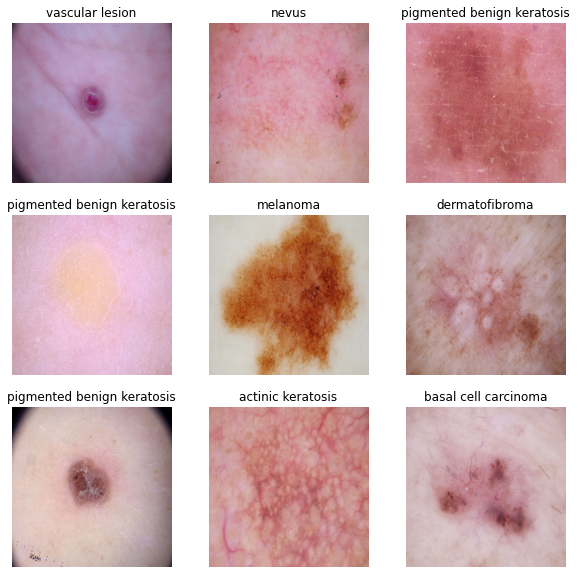

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 3.Model Building & Training

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
### Normalization
normalization_layer = layers.Rescaling(1./255)

In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image)) 

0.15555541 0.80163413


In [13]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [14]:
### Choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 41s 752ms/step - loss: 1.7585 - accuracy: 0.3700 - val_loss: 1.6041 - val_accuracy: 0.4497
Epoch 2/20
56/56 [==============================] - 3s 47ms/step - loss: 1.5314 - accuracy: 0.4715 - val_loss: 1.5690 - val_accuracy: 0.4519
Epoch 3/20
56/56 [==============================] - 3s 45ms/step - loss: 1.4107 - accuracy: 0.5184 - val_loss: 1.3919 - val_accuracy: 0.5369
Epoch 4/20
56/56 [==============================] - 3s 45ms/step - loss: 1.3068 - accuracy: 0.5413 - val_loss: 1.3651 - val_accuracy: 0.5526
Epoch 5/20
56/56 [==============================] - 3s 45ms/step - loss: 1.1928 - accuracy: 0.5742 - val_loss: 1.3454 - val_accuracy: 0.5391
Epoch 6/20
56/56 [==============================] - 3s 45ms/step - loss: 1.1451 - accuracy: 0.5887 - val_loss: 1.4003 - val_accuracy: 0.5638
Epoch 7/20
56/56 [==============================] - 3s 46ms/step - loss: 1.0655 - accuracy: 0.6150 - val_loss: 1.5161 - val_accuracy: 0.5078
Epoch 8/20


### Visualizing training results

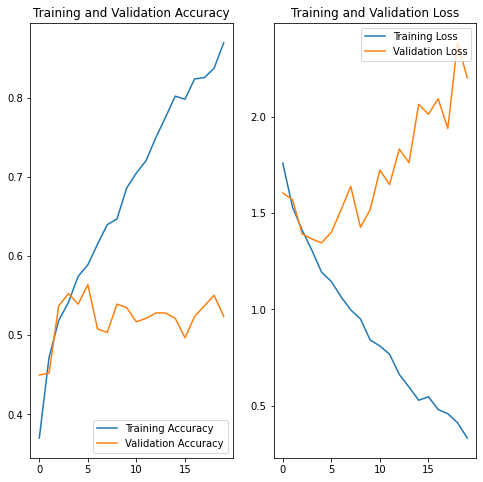

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model is overfitting
-----------------
In the plots above, the training accuracy is pretty high nearly 88%, whereas validation accuracy is at around 55% in the training process. Also, the difference between training and validation accuracy is significant which is a clear sign of overfitting.


# 4. Choosing data augmentation strategy to resolve underfitting/overfitting

# Data Augmentation

In [19]:
# After you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

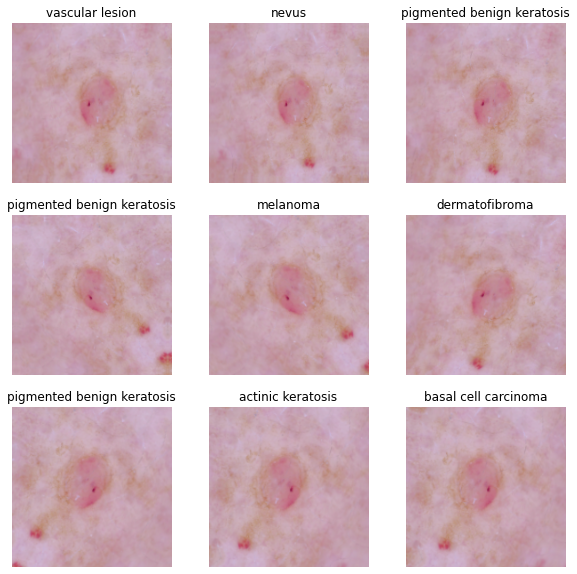

In [20]:
# Visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# 5. Model Building & training on the augmented data

### Create the model, compile and train the model


In [21]:

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compiling the model

In [22]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

### Training the model

In [24]:
## Train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 57ms/step - loss: 1.9531 - accuracy: 0.2673 - val_loss: 1.7453 - val_accuracy: 0.3289
Epoch 2/20
56/56 [==============================] - 3s 53ms/step - loss: 1.7096 - accuracy: 0.3700 - val_loss: 1.6158 - val_accuracy: 0.4273
Epoch 3/20
56/56 [==============================] - 3s 52ms/step - loss: 1.5158 - accuracy: 0.4660 - val_loss: 1.5087 - val_accuracy: 0.4944
Epoch 4/20
56/56 [==============================] - 3s 52ms/step - loss: 1.4341 - accuracy: 0.5112 - val_loss: 1.4107 - val_accuracy: 0.4966
Epoch 5/20
56/56 [==============================] - 3s 52ms/step - loss: 1.3452 - accuracy: 0.5290 - val_loss: 1.4021 - val_accuracy: 0.5213
Epoch 6/20
56/56 [==============================] - 3s 52ms/step - loss: 1.2972 - accuracy: 0.5463 - val_loss: 1.4073 - val_accuracy: 0.5347
Epoch 7/20
56/56 [==============================] - 3s 53ms/step - loss: 1.3500 - accuracy: 0.5229 - val_loss: 1.4359 - val_accuracy: 0.4989
Epoch 8/20
56

### Visualizing the results

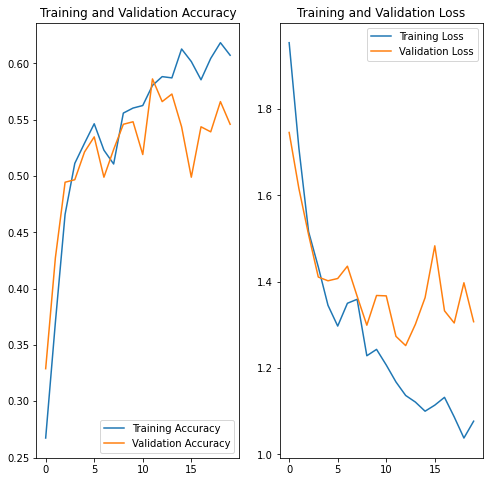

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings after the model fit to see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

------------------------------------

- The model seems to have improved.
- As we can observe from the above plots,the training and validation accuracies are in-line with each other and are more closely algined.
- After applying data augmentation and Dropout, there is less overfitting than before.
- The train and validation accuracies at ~60% and ~55% respectively are also comparable.

# 6. Examine the class distribution

#### **Find the distribution of classes in the training dataset.**
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [26]:
# Test the distribution of images in each class in the dataset to find if class imbalance is present
class_image_count = {}
train_images_path = pathlib.Path("/content/gdrive/My Drive/Colab Notebooks/Melanoma_Detection/Train/")
for i in class_names:
  data_dir = pathlib.Path(train_images_path).joinpath(i)
  image_count = len(list(data_dir.glob('*.jpg')))
  class_image_count[i] = image_count


df = pd.DataFrame(class_image_count.values(),index=class_image_count.keys(),columns=['Count'])
print(df.sort_values(by=['Count'], ascending=False))


                            Count
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77


#### Findings: 
- There is a significant difference in the distribution of images across classes which we need to handle in order to make our model work better.



#### - Which class has the least number of samples? 
---
***Seborrheic Keratosis***

#### - Which classes dominate the data in terms proportionate number of samples? 
---
  ***Pigmented Benign Keratosis***


# 7. Handling class imbalances

#### **Rectify the class imbalance**
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [27]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
path_to_training_dataset=pathlib.Path("/content/gdrive/My Drive/Colab Notebooks/Melanoma_Detection/Train/")
import Augmentor
for i in class_names:
    data_dir_aug = pathlib.Path(train_images_path).joinpath(i)
    p = Augmentor.Pipeline(data_dir_aug)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Melanoma_Detection/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FCA2E30FD10>: 100%|██████████| 500/500 [00:25<00:00, 19.27 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Melanoma_Detection/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FCA2E253890>: 100%|██████████| 500/500 [00:25<00:00, 19.92 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Melanoma_Detection/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FCA2E0B0650>: 100%|██████████| 500/500 [00:26<00:00, 18.91 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Melanoma_Detection/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x7FCA2E2577D0>: 100%|██████████| 500/500 [01:46<00:00,  4.69 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Melanoma_Detection/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FCA2E1FFE90>: 100%|██████████| 500/500 [01:28<00:00,  5.62 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Melanoma_Detection/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC93BA27590>: 100%|██████████| 500/500 [00:22<00:00, 22.52 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Melanoma_Detection/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FC9B5919310>: 100%|██████████| 500/500 [00:50<00:00,  9.96 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Melanoma_Detection/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FCA2E2D2810>: 100%|██████████| 500/500 [00:21<00:00, 23.24 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Melanoma_Detection/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FCA2E25D950>: 100%|██████████| 500/500 [00:22<00:00, 22.45 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [30]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/My Drive/Colab Notebooks/Melanoma_Detection/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027172.jpg_1c3366bf-1107-4f09-beac-1d74a382eb04.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/Melanoma_Detection/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028190.jpg_0dc10e54-0365-41a2-8ba9-a29a336b1710.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/Melanoma_Detection/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028854.jpg_819f925f-5e20-401b-827e-e240d9d3c5d2.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/Melanoma_Detection/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033456.jpg_f7c6d93e-ea5b-4cb6-bc6c-8aea5d515a39.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/Melanoma_Detection/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026702.jpg_2f78d207-862e-4b2c-b47e-37e71af5d01f.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/Melanoma_Detection/Train/actinic keratosis/output/actinic

In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [32]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','*.jpg'))]
dataframe_dict = dict(zip(path_list, lesion_list))

In [33]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [34]:
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [35]:
new_df.head(10)

,Path,Label
0,/content/gdrive/My Drive/Colab Notebooks/Melan...,Train
1,/content/gdrive/My Drive/Colab Notebooks/Melan...,Train
2,/content/gdrive/My Drive/Colab Notebooks/Melan...,Train
3,/content/gdrive/My Drive/Colab Notebooks/Melan...,Train
4,/content/gdrive/My Drive/Colab Notebooks/Melan...,Train
5,/content/gdrive/My Drive/Colab Notebooks/Melan...,Train
6,/content/gdrive/My Drive/Colab Notebooks/Melan...,Train
7,/content/gdrive/My Drive/Colab Notebooks/Melan...,Train
8,/content/gdrive/My Drive/Colab Notebooks/Melan...,Train
9,/content/gdrive/My Drive/Colab Notebooks/Melan...,Train


In [36]:
new_df['Label'].value_counts()

Train                         2239
actinic keratosis              500
melanoma                       500
vascular lesion                500
seborrheic keratosis           500
nevus                          500
pigmented benign keratosis     500
dermatofibroma                 500
squamous cell carcinoma        500
basal cell carcinoma           500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

# 8. Model Building & training on the rectified class imbalance data

#### Train the model on the data created using Augmentor

In [37]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [38]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training", ## Choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [39]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",## Choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create your model (make sure to include normalization)

In [40]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [41]:
# Performing normalization of data
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image)) 

0.045914598 0.8326801


In [42]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(8, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.1),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.1),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.1),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.1),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(num_classes)
])

#### Compile your model (Choose optimizer and loss function appropriately)

In [43]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [44]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 8)       224       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 8)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 90, 90, 8)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 16)        1168      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 16)       0         
 2D)                                                  

#### Train your model

In [45]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 14s 78ms/step - loss: 1.9699 - accuracy: 0.2266 - val_loss: 1.8936 - val_accuracy: 0.2717
Epoch 2/30
169/169 [==============================] - 6s 34ms/step - loss: 1.7535 - accuracy: 0.3138 - val_loss: 1.7162 - val_accuracy: 0.3267
Epoch 3/30
169/169 [==============================] - 6s 34ms/step - loss: 1.6198 - accuracy: 0.3811 - val_loss: 1.4545 - val_accuracy: 0.4484
Epoch 4/30
169/169 [==============================] - 6s 34ms/step - loss: 1.4504 - accuracy: 0.4499 - val_loss: 1.3571 - val_accuracy: 0.4929
Epoch 5/30
169/169 [==============================] - 6s 34ms/step - loss: 1.3456 - accuracy: 0.4915 - val_loss: 1.2629 - val_accuracy: 0.5338
Epoch 6/30
169/169 [==============================] - 6s 34ms/step - loss: 1.2867 - accuracy: 0.5184 - val_loss: 1.3492 - val_accuracy: 0.5004
Epoch 7/30
169/169 [==============================] - 6s 34ms/step - loss: 1.1767 - accuracy: 0.5569 - val_loss: 1.1229 - val_accuracy: 0.580

#### Visualize the model results

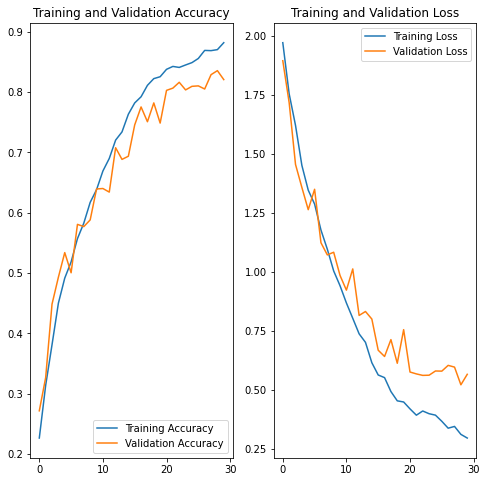

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



---
- The training accuracy seems to be nearly ~88%.The validation accuracy is nearly ~84%.
- The class rebalancing has helped to treat the overfitting to some extent.
- There has been an increase in the model accuracies as well.